# Albumentations Modeling Notebook

## Importing Packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16

%reload_ext autoreload
%autoreload 2
from utils import *


## Setting up ImageDataGenerators

In [2]:
datagen = build_datagenerator(dir1="../sample/train",
                              dir2="../sample/aug",
                              batch_size=16)

Found 3216 images belonging to 2 classes.
Found 614 images belonging to 2 classes.


In [3]:
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode='binary')

Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [9]:
X_tr, y_tr = next(datagen)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

TypeError: 'MergedGenerators' object is not an iterator

## CNN Model

In [4]:
def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
        ])
        # sigmoid also

model = create_model((224, 224, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')],
              run_eagerly = True)


In [7]:
filepath = '../models/CNN_v2.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = datagen,
                              verbose = 1,
                              epochs = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = int(239/16))

Epoch 1/20
14/14 [==============================] - 539s 40s/step - loss: 0.3883 - accuracy: 0.8214 - precision: 0.8133 - recall: 0.9375 - auc: 0.8767 - auc_1: 0.9116 - val_loss: 1.2705 - val_accuracy: 0.8127 - val_precision: 0.9516 - val_recall: 0.8477 - val_auc: 0.4670 - val_auc_1: 0.9622
Epoch 2/20
14/14 [==============================] - 601s 45s/step - loss: 0.2582 - accuracy: 0.8884 - precision: 0.8764 - recall: 0.9811 - auc: 0.9325 - auc_1: 0.9703 - val_loss: 0.5718 - val_accuracy: 0.8864 - val_precision: 0.9555 - val_recall: 0.9246 - val_auc: 0.5846 - val_auc_1: 0.9749
Epoch 3/20
14/14 [==============================] - 522s 39s/step - loss: 0.3554 - accuracy: 0.8482 - precision: 0.8182 - recall: 0.9863 - auc: 0.8824 - auc_1: 0.9224 - val_loss: 0.4774 - val_accuracy: 0.8643 - val_precision: 0.9544 - val_recall: 0.9015 - val_auc: 0.5734 - val_auc_1: 0.9734
Epoch 4/20
14/14 [==============================] - 482s 36s/step - loss: 0.2950 - accuracy: 0.8795 - precision: 0.8671 - re

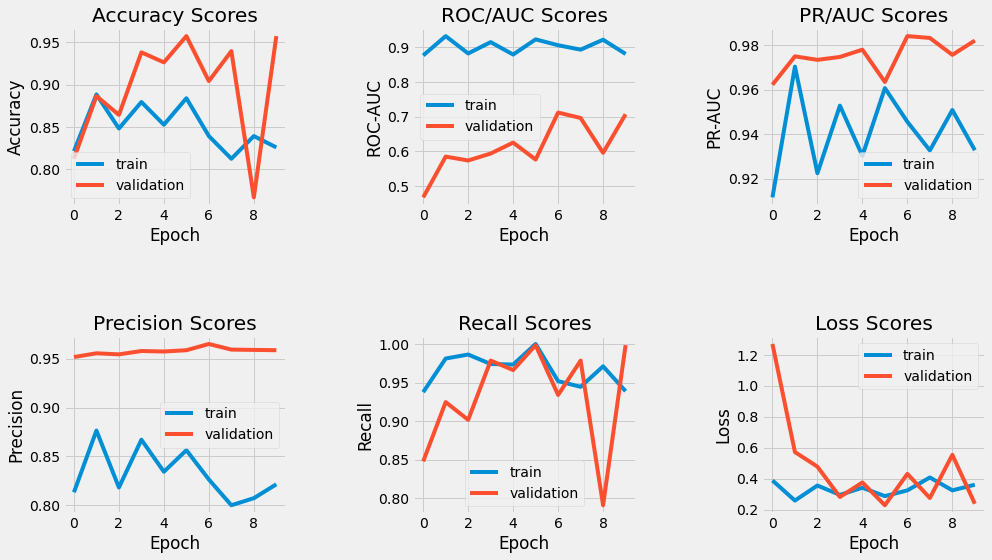

In [15]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [16]:
hist_df_1 = pd.DataFrame(history.history)
hist_df_1

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,0.388307,0.821429,0.813253,0.937500,0.876693,0.911576,1.270467,0.812684,0.951641,0.847692,0.466951,0.962202
1,0.258172,0.888393,0.876405,0.981132,0.932511,0.970341,0.571774,0.886431,0.955485,0.924615,0.584643,0.974945
2,0.355431,0.848214,0.818182,0.986301,0.882420,0.922415,0.477406,0.864307,0.954397,0.901538,0.573407,0.973383
3,0.294965,0.879464,0.867052,0.974026,0.915074,0.952803,0.281357,0.938053,0.957831,0.978462,0.593462,0.974681
4,0.341141,0.852679,0.834286,0.973333,0.879324,0.930262,0.375293,0.926254,0.957317,0.966154,0.625082,0.977952
5,0.286811,0.883929,0.856354,1.000000,0.923048,0.960677,0.227949,0.957227,0.958641,0.998462,0.575962,0.963447
6,0.323941,0.839286,0.826347,0.951724,0.906155,0.945543,0.430765,0.904130,0.965024,0.933846,0.711758,0.984051
7,0.407510,0.812500,0.800000,0.944444,0.893403,0.932675,0.274736,0.939528,0.959276,0.978462,0.696126,0.983217
8,0.324102,0.839286,0.807229,0.971014,0.922059,0.950832,0.553679,0.766962,0.958955,0.790769,0.595440,0.975621
9,0.360459,0.825893,0.821429,0.938776,0.880952,0.932772,0.237545,0.957227,0.958641,0.998462,0.706896,0.982051


# VGG16

In [17]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(inputs=input_, outputs=last_layer)

model.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
filepath = '../models/CNN_v3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history3 = model.fit_generator(generator = datagen,
                               verbose = 1,
                               epochs = 20,
                               callbacks = [earlyStopping, mcp_save],
                               validation_data = val_generator,
                               steps_per_epoch = int(239/16))

Epoch 1/5
20/20 [==============================] - 378s 19s/step - loss: 5.6619 - accuracy: 0.6812 - precision_3: 0.7609 - recall_3: 0.7446 - auc_6: 0.6608 - auc_7: 0.7520 - val_loss: 0.3919 - val_accuracy: 0.9719 - val_precision_3: 0.9780 - val_recall_3: 0.9936 - val_auc_6: 0.5257 - val_auc_7: 0.9792
Epoch 2/5
20/20 [==============================] - 565s 29s/step - loss: 1.0053 - accuracy: 0.8828 - precision_3: 0.8834 - recall_3: 0.9504 - auc_6: 0.8815 - auc_7: 0.8978 - val_loss: 0.4489 - val_accuracy: 0.9484 - val_precision_3: 0.9805 - val_recall_3: 0.9663 - val_auc_6: 0.7266 - val_auc_7: 0.9858
Epoch 3/5
20/20 [==============================] - 536s 27s/step - loss: 0.8678 - accuracy: 0.8812 - precision_3: 0.8971 - recall_3: 0.9233 - auc_6: 0.9124 - auc_7: 0.9251 - val_loss: 0.2373 - val_accuracy: 0.9391 - val_precision_3: 0.9934 - val_recall_3: 0.9448 - val_auc_6: 0.7112 - val_auc_7: 0.9949
Epoch 4/5
 9/20 [============>.................] - ETA: 2:10 - loss: 0.6269 - accuracy: 0.9

UnknownError:  OSError: image file is truncated (11 bytes not processed)
Traceback (most recent call last):

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "<ipython-input-3-9826ca7ec8fd>", line 28, in __getitem__
    x1, y1 = generator[index % len(generator)]

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/Image.py", line 1916, in resize
    self.load()

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/ImageFile.py", line 260, in load
    "image file is truncated "

OSError: image file is truncated (11 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_106086]

Function call stack:
train_function
